In [3]:
import pandas as pd

# Wczytanie danych
df = pd.read_csv('sport.csv')

# Wyświetlenie podstawowych informacji
print(df.head())
print(df.info())


   Unnamed: 0  sex        date  age  height  weight discipline  AeT  AnT  \
0           0    1  2023-07-21   45     184    81.0    running  128  157   
1           1    0  2023-08-04   33     171    64.0    running  171  184   
2           2    1  2023-08-04   38     185    72.0    running  157  178   
3           3    1  2023-08-04   37     182    81.0  triathlon  134  176   
4           4    1  2023-08-02   40     175    72.0    running  139  158   

   vo2max  ...  hr_18  la_18  hr_20  la_20  hr_22  la_22   z2   z3   z4   z5  
0    56.3  ...  165.0   12.3    NaN    NaN    NaN    NaN  121  129  149  158  
1    52.8  ...  197.0    NaN    NaN    NaN    NaN    NaN  154  172  178  185  
2    56.2  ...  178.0    3.6    NaN    NaN    NaN    NaN  138  158  167  179  
3    53.3  ...  180.0    NaN    NaN    NaN    NaN    NaN  123  135  162  177  
4    58.7  ...    NaN    NaN    NaN    NaN    NaN    NaN  126  140  152  159  

[5 rows x 38 columns]
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [4]:
df = df.drop(columns=['Unnamed: 0'])


In [62]:
gf\

fggfd

NameError: name 'gf' is not defined

In [63]:
jhk

NameError: name 'jhk' is not defined

In [64]:
klj

NameError: name 'klj' is not defined

In [65]:
lkj

NameError: name 'lkj' is not defined

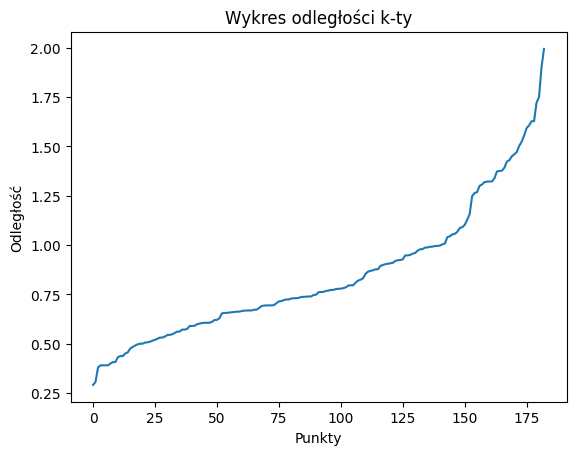

Wykryte klastry: 5
Liczba punktów szumowych: 150


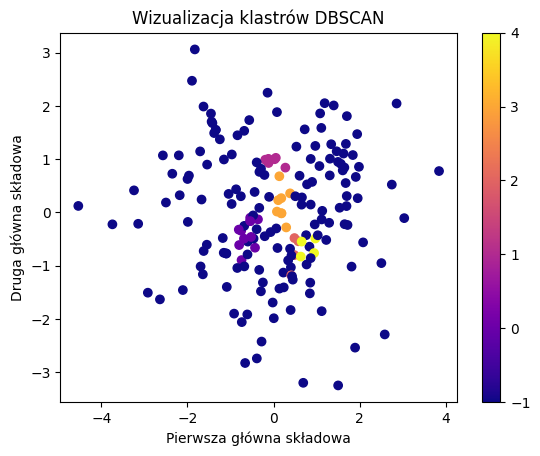

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Wypełnianie brakujących wartości
df['weight'] = df['weight'].fillna(df['weight'].mean())
df['height'] = df['height'].fillna(df['height'].mean())

# Wybór cech do klasteryzacji
features = df[['age', 'height', 'weight', 'vo2max']]

# Normalizacja danych
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Analiza k-distance
neighbors = NearestNeighbors(n_neighbors=4)  # min_samples = 4
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

# Sortowanie i rysowanie wykresu odległości k-tej
distances = np.sort(distances[:, 3], axis=0)
plt.plot(distances)
plt.title('Wykres odległości k-ty')
plt.xlabel('Punkty')
plt.ylabel('Odległość')
plt.show()

# Ustalenie wartości eps i min_samples
eps_value = 0.5  # Ustalona wartość
min_samples_value = 4  # Ustalona wartość

# Zastosowanie DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters = dbscan.fit_predict(scaled_features)

# Dodanie wyników klasteryzacji do DataFrame
df['cluster'] = clusters

# Sprawdzenie wyników klasteryzacji
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f'Wykryte klastry: {num_clusters}')
print(f'Liczba punktów szumowych: {list(clusters).count(-1)}')

# Wizualizacja klastrów
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='plasma')
plt.title('Wizualizacja klastrów DBSCAN')
plt.xlabel('Pierwsza główna składowa')
plt.ylabel('Druga główna składowa')
plt.colorbar()
plt.show()
